In [105]:
from pathlib import Path
import os
from os.path import join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import re
from gelgenie.segmentation.helper_functions.general_functions import create_dir_if_empty

#### Main data prep functions

In [106]:
def modify_keys_and_add_prefix(data_dict, prefix):
    """
    Modify keys in a dictionary by removing a prefix and adding a new prefix.

    Parameters:
    - data_dict (dict): The input dictionary to be modified.
    - prefix (str): The prefix to be added to the modified keys.

    Modifies the keys in the input dictionary by removing a prefix (if present) and adding a new prefix.
    The modified dictionary is updated in-place.

    Example:
    >>> data_dict = {'old\\key_1': 10, 'old\\key_2': 20}
    >>> modify_keys_and_add_prefix(data_dict, 'new_')
    >>> print(data_dict)
    {'new_key1': 10, 'new_key2': 20}
    """
    # Iterate over a copy of keys to avoid changing the dictionary size during iteration
    for old_key in list(data_dict.keys()):
        # Find the index of the backslash character
        index = old_key.find("\\")
        
        # If the backslash is present, create a new key starting from the character after the backslash
        if index != -1:
            new_key = old_key[index + 1:]
        else:
            # If no backslash is found, use the original key
            new_key = old_key
        
        # Remove any underscores after the backslash (if present)
        new_key = new_key.split('_')[0] if '_' in new_key else new_key
        
        # Add the new prefix to the modified key
        new_key = f"{prefix}{new_key}"
        
        # Update the dictionary with the modified key
        data_dict[new_key] = data_dict.pop(old_key)


def min_max_normalize(df, group_column, target_column, new_column_name=None):
    """
    Min-Max normalize the values of a column in a Pandas DataFrame grouped by another column.

    Parameters:
    - df: Pandas DataFrame
    - group_column: Column used for grouping
    - target_column: Column to be min-max normalized
    - new_column_name: Name for the new column with normalized values (default is 'Normalized_<target_column>')

    Returns:
    - df_normalized: DataFrame with the new column containing min-max normalized values within each group
    """
    # If new_column_name is not provided, create a default name
    if new_column_name is None:
        new_column_name = f'Normalized_{target_column}'

    # Calculate the min and max values for each group
    min_values = df.groupby(group_column)[target_column].transform('min')
    max_values = df.groupby(group_column)[target_column].transform('max')

    # Apply the min-max normalization formula and add a new column
    df[new_column_name] = (df[target_column] - min_values) / (max_values - min_values)

    return df

def load_ga_csv_files_from_folders(parent_folder, prefix="ga_"):
    """
    Load CSV files from folders and create a dictionary of DataFrames with prefixed names.

    Parameters:
    - parent_folder (str): The path to the parent folder containing numbered subfolders.
    - prefix (str): The prefix to be added to the names of the DataFrames (default is "ga_").

    Returns:
    - dataframes (dict): A dictionary where keys are prefixed folder names, and values are corresponding DataFrames.
    """
    dataframes = {}  # Dictionary to store DataFrames

    # Iterate through folders in the parent folder
    for folder_name in os.listdir(parent_folder):
        folder_path = os.path.join(parent_folder, folder_name)

        # Check if the item in the parent folder is a directory
        if os.path.isdir(folder_path):
            csv_file_path = os.path.join(folder_path, "collated_data_with_band_quality.csv")

            # Check if "collated_data_with_band_quality.csv" exists in the folder
            if os.path.isfile(csv_file_path):
                # Read the CSV file into a DataFrame
                dataframe = pd.read_csv(csv_file_path)

                # Add the prefix to the folder name and use it as the key in the dictionary
                prefixed_folder_name = f"{prefix}{folder_name}"
                dataframes[prefixed_folder_name] = dataframe

    return dataframes

def min_max_normalize_multiple_inplace(dataframes_dict, group_column, target_columns, new_column_prefix=None):
    """
    Min-Max normalize the values of specified columns in multiple DataFrames stored in a dictionary.
    Add normalized columns to the existing DataFrames.

    Parameters:
    - dataframes_dict (dict): A dictionary where keys are DataFrame names and values are DataFrames.
    - group_column (str): Column used for grouping in each DataFrame.
    - target_columns (list): List of columns to be min-max normalized in each DataFrame.
    - new_column_prefix (str): Prefix for the new columns with normalized values (default is 'Normalized_').

    Modifies the input DataFrames in-place by adding normalized columns.

    Example:
    >>> dataframes_dict = {'df1': pd.DataFrame({'Group': ['A', 'A', 'B', 'B'], 'Values1': [10, 15, 5, 8]}),
                           'df2': pd.DataFrame({'Group': ['C', 'C', 'D', 'D'], 'Values1': [50, 55, 45, 60]})}
    >>> min_max_normalize_multiple_inplace(dataframes_dict, group_column='Group', target_columns=['Values1'])
    >>> print(dataframes_dict['df1'])
       Group  Values1  Normalized_Values1
    0     A       10                0.00
    1     A       15                1.00
    2     B        5                0.00
    3     B        8                1.00
    """
    # If new_column_prefix is not provided, create a default name
    if new_column_prefix is None:
        new_column_prefix = 'Normalized_'

    # Iterate through DataFrames in the dictionary
    for df_name, df in dataframes_dict.items():
        # Iterate through target columns in each DataFrame
        for target_column in target_columns:
            # Calculate the min and max values for each group in the current DataFrame
            min_values = df.groupby(group_column)[target_column].transform('min')
            max_values = df.groupby(group_column)[target_column].transform('max')

            # Add a new column with the normalized values to the existing DataFrame
            new_column_name = f"{new_column_prefix}{target_column}"
            df[new_column_name] = (df[target_column] - min_values) / (max_values - min_values)

        # Update the dictionary with the modified DataFrame
        dataframes_dict[df_name] = df

        
def load_gg_csv_files_to_dict(folder_path, prefix="prefix_"):
    """
    Load CSV files from a folder and create a dictionary of DataFrames with prefixed keys.

    Parameters:
    - folder_path (str): The path to the folder containing CSV files.
    - prefix (str): The prefix to be added to the keys of the dictionary (default is "prefix_").

    Returns:
    - dataframes_dict (dict): A dictionary where keys are prefixed numbers, and values are corresponding DataFrames.
    """
    dataframes_dict = {}  # Dictionary to store DataFrames

    # Iterate through files in the folder
    for filename in os.listdir(folder_path):
        # Check if the file is a CSV file
        if filename.endswith(".csv"):
            # Extract the number from the filename
            file_number = filename.split("_")[0]

            # Read the CSV file into a DataFrame
            file_path = os.path.join(folder_path, filename)
            dataframe = pd.read_csv(file_path)

            # Add the prefix to the number and use it as the key in the dictionary
            key = f"{prefix}{file_number}"
            dataframes_dict[key] = dataframe

    return dataframes_dict


def remove_spaces_from_column_headings_inplace(dataframes_dict):
    """
    Remove spaces at the start and end of column headings in pandas DataFrames stored in a dictionary.
    Replace the old columns with the modified column headings in-place.

    Parameters:
    - dataframes_dict (dict): A dictionary where keys are DataFrame names and values are DataFrames.

    Modifies the input DataFrames in-place by replacing old columns with modified column headings.
    """
    # Iterate through DataFrames in the dictionary
    for df_name, df in dataframes_dict.items():
        # Remove spaces at the start and end of column headings and replace the old columns
        df.columns = df.columns.str.strip()

        # Update the dictionary with the modified DataFrame
        dataframes_dict[df_name] = df

#### Data Preprocessing

In [107]:
# modify the below paths to point to wherever the gelgenie (gg)/gelanalyzer (ga)/ reference data is stored
gg_path = Path("/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/quantitative_results/qupath_data/james_data_v3_fixed_global/Data")
ga_path = Path("/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/quantitative_results/gelanalyzer")
reference_path = Path("/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/quantitative_results/reference_ladder_masses.csv")

gg_dfs = load_gg_csv_files_to_dict(gg_path, "gg_") # loads data and converts to dictionary
remove_spaces_from_column_headings_inplace(gg_dfs) # deletes spaces from column headings (due to an old bug that has now been fixed)

gg_dfs = {key: gg_dfs[key] for key in sorted(gg_dfs.keys(), key=lambda s: [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', s)])}  # sorts by gel ID

ga_dfs = load_ga_csv_files_from_folders(ga_path)
ga_dfs = {key: ga_dfs[key] for key in sorted(ga_dfs.keys(), key=lambda s: [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', s)])} # sorts by gel ID

for key, df in ga_dfs.items():
    ga_dfs[key] = df[df['Reliable Band'] != 0].copy() # removes all band data that has been deemed as unreliable

reference_df = pd.read_csv(reference_path)
reference_df.rename(columns={"NEB ladder": "NEB", " ThermoFisher ladder": "Thermo"}, inplace=True)
reference_df["Band ID"] = range(1, len(reference_df) + 1)
reference_df = pd.melt(reference_df, id_vars=["Band ID"], value_vars=["NEB", "Thermo"], var_name="Ladder", value_name="Intensity")
reference_df['Normalized_Intensity'] = reference_df.groupby("Ladder")["Intensity"].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
print('reference data:')
reference_df

reference data:


,Band ID,Ladder,Intensity,Normalized_Intensity
0,1,NEB,40.0,0.168317
1,2,NEB,40.0,0.168317
2,3,NEB,48.0,0.247525
3,4,NEB,40.0,0.168317
4,5,NEB,32.0,0.089109
5,6,NEB,120.0,0.960396
6,7,NEB,40.0,0.168317
7,8,NEB,57.0,0.336634
8,9,NEB,45.0,0.217822
9,10,NEB,122.0,0.980198


In [108]:
print('Example gelgenie data:')
gg_dfs['gg_0']

Example gelgenie data:


,Lane ID,Band ID,Pixel Count,Average Intensity,Raw Volume,Local Corrected Volume,Global Corrected Volume
0,1,1,376,26.015957,9782,4856.063857,5297.103333
1,1,2,409,30.677262,12547,7064.778191,7668.482083
2,1,3,367,31.940054,11722,6146.662321,7344.454583
3,1,4,351,33.413105,11728,5660.595745,7541.301250
4,1,5,395,30.524051,12057,6270.890274,7345.472917
...,...,...,...,...,...,...,...
211,12,14,492,43.217480,21263,11534.032430,15394.465000
212,12,15,501,40.638723,20360,10766.295490,14384.113750
213,12,16,515,38.761165,19962,9940.058187,13819.122920
214,12,17,582,31.378007,18262,8060.949640,11319.952500


In [109]:
print('Example gelanalyzer data:')
ga_dfs['ga_31']

Example gelanalyzer data:


,Lane ID,Band ID,Raw Volume,Background Corrected Volume,Reliable Band
0,1,1,1891,916,1
1,1,2,1847,827,1
2,1,3,2019,1073,1
3,1,4,1900,881,1
4,1,5,2046,735,1
...,...,...,...,...,...
223,12,15,3145,1329,1
224,12,16,1802,447,1
225,12,17,1751,342,1
226,12,18,1394,242,1


#### Normalization

In [110]:
ga_columns = ['Raw Volume', 'Background Corrected Volume']
gg_columns = ['Raw Volume','Local Corrected Volume', 'Global Corrected Volume']

min_max_normalize_multiple_inplace(ga_dfs, 'Lane ID', ga_columns)  
min_max_normalize_multiple_inplace(gg_dfs, 'Lane ID', gg_columns)

normalized_gg_columns = ['Normalized_Raw Volume', 'Normalized_Local Corrected Volume', 'Normalized_Global Corrected Volume']
normalized_ga_columns = ['Normalized_Raw Volume', 'Normalized_Background Corrected Volume']

#### Concatenation and final DF generation

In [111]:
for key, df in gg_dfs.items():
    df['App'] = "GG"
    df['Gel ID'] = key
    
for key, df in ga_dfs.items():
    df['App'] = "GA"
    df['Gel ID'] = key
    
concatenated_df = pd.concat([df for df in gg_dfs.values()] + [df for df in ga_dfs.values()], ignore_index=True)
concatenated_df['Gel ID'] = concatenated_df['Gel ID'].str.extract(r'_(\d+)')
concatenated_df['Gel ID'] = concatenated_df['Gel ID'].astype(int)
concatenated_df['Ladder'] = "Temp"
concatenated_df.loc[concatenated_df["Gel ID"].isin([0,1,2,3,4,5,6,7,8,9,10,11,12,32,34]), "Ladder"] = "Thermo"
concatenated_df.loc[concatenated_df["Gel ID"].isin([13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,29,30,31,33]), "Ladder"] = "NEB"

In [112]:
concatenated_df[concatenated_df['Gel ID'] == 32]

,Lane ID,Band ID,Pixel Count,Average Intensity,Raw Volume,Local Corrected Volume,Global Corrected Volume,Normalized_Raw Volume,Normalized_Local Corrected Volume,Normalized_Global Corrected Volume,App,Gel ID,Background Corrected Volume,Reliable Band,Normalized_Background Corrected Volume,Ladder
5525,1,1,297.0,107.117845,31814.0,9542.270270,16615.449286,0.000000,0.083733,0.000000,GG,32,NaN,NaN,NaN,Thermo
5526,1,2,322.0,110.329193,35526.0,7815.346629,19048.110000,0.070234,0.015447,0.080351,GG,32,NaN,NaN,NaN,Thermo
5527,1,3,312.0,113.445513,35395.0,7424.710983,19428.845714,0.067755,0.000000,0.092927,GG,32,NaN,NaN,NaN,Thermo
5528,1,4,318.0,117.003145,37207.0,8618.736527,20933.804286,0.102040,0.047214,0.142636,GG,32,NaN,NaN,NaN,Thermo
5529,1,5,346.0,113.875723,39401.0,10436.250996,21694.944286,0.143552,0.119083,0.167776,GG,32,NaN,NaN,NaN,Thermo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5736,12,14,812.0,137.464286,111621.0,28657.534351,70068.060000,0.794712,0.635444,0.778690,GG,32,NaN,NaN,NaN,Thermo
5737,12,15,769.0,139.535761,107303.0,24672.983920,67950.523571,0.747398,0.513160,0.744016,GG,32,NaN,NaN,NaN,Thermo
5738,12,16,820.0,135.695122,111270.0,27843.686441,69307.671429,0.790866,0.610468,0.766239,GG,32,NaN,NaN,NaN,Thermo
5739,12,17,768.0,137.653646,105718.0,24784.352941,66416.697143,0.730030,0.516578,0.718900,GG,32,NaN,NaN,NaN,Thermo


<AxesSubplot:xlabel='Lane ID', ylabel='Normalized_Raw Volume'>

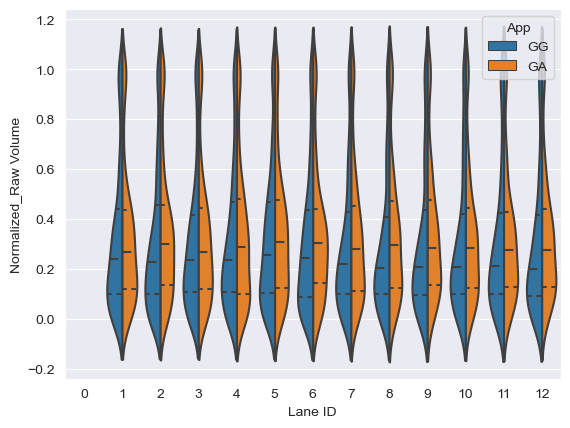

In [113]:
sns.violinplot(data=concatenated_df, x='Lane ID', y='Normalized_Raw Volume', hue='App', split=True, inner='quart')

In [114]:
melted_df = pd.melt(concatenated_df, id_vars=['Lane ID', 'Band ID', 'Gel ID', 'App'],
                    value_vars=['Pixel Count', 'Average Intensity', 'Raw Volume', 'Local Corrected Volume',
                                'Global Corrected Volume', 'Normalized_Raw Volume',
                                'Normalized_Local Corrected Volume', 'Normalized_Global Corrected Volume',
                                'Background Corrected Volume', 'Normalized_Background Corrected Volume'],
                    var_name='Variable', value_name='Volume')

In [115]:
melted_df # this df contains all the data split into rows for every single variable e.g. there is a single row for a normalised background value of a single band ID and lane ID.  The descriptor is held in the Variable column and the value is held in the Volumn column

,Lane ID,Band ID,Gel ID,App,Variable,Volume
0,1,1,0,GG,Pixel Count,376.000000
1,1,2,0,GG,Pixel Count,409.000000
2,1,3,0,GG,Pixel Count,367.000000
3,1,4,0,GG,Pixel Count,351.000000
4,1,5,0,GG,Pixel Count,395.000000
...,...,...,...,...,...,...
106715,12,15,31,GA,Normalized_Background Corrected Volume,0.933440
106716,12,16,31,GA,Normalized_Background Corrected Volume,0.226143
106717,12,17,31,GA,Normalized_Background Corrected Volume,0.141941
106718,12,18,31,GA,Normalized_Background Corrected Volume,0.061748


#### Violin: General vs Local Background Correction (GG)

In [116]:
# Select rows based on the 'Variable' column
selected_variables = ['Normalized_Local Corrected Volume', 'Normalized_Global Corrected Volume']
#additional_column_value = 'GA'  # Replace with the specific value you want to filter on
subset_df = melted_df[(melted_df['Variable'].isin(selected_variables))]
#subset_df = melted_df[(melted_df['Variable'].isin(selected_variables)) & (melted_df['App'] == additional_column_value)]

# Get unique values in the "Gel ID" column
unique_gel_ids = concatenated_df['Gel ID'].unique()

output_dir = '/Users/matt/Desktop/violin_localvsglobal'

create_dir_if_empty(output_dir)

for gel_id in unique_gel_ids:
    subset_df = melted_df[(melted_df['Variable'].isin(selected_variables)) & (melted_df['Gel ID'] == gel_id)]

    # Plot the violin plot with log scale on the y-axis
    sns.violinplot(data=subset_df, x='Lane ID', y='Volume', hue='Variable', split=True, inner='quart')

    plt.title(f"Gel - {gel_id}")
    plt.savefig(os.path.join(output_dir, f"gel_{gel_id}.jpg"))
    plt.close()

#### Violin: GA vs GG (raw)

In [117]:
# Select rows based on the 'Variable' column
selected_variables = ['Normalized_Raw Volume']
#additional_column_value = 'GA'  # Replace with the specific value you want to filter on
subset_df = melted_df[(melted_df['Variable'].isin(selected_variables))]
#subset_df = melted_df[(melted_df['Variable'].isin(selected_variables)) & (melted_df['App'] == additional_column_value)]

# Get unique values in the "Gel ID" column
unique_gel_ids = concatenated_df['Gel ID'].unique()

output_dir = '/Users/matt/Desktop/violin_raw_ggvsga'

create_dir_if_empty(output_dir)

for gel_id in unique_gel_ids:
    
    subset_df = melted_df[(melted_df['Variable'].isin(selected_variables)) & (melted_df['Gel ID'] == gel_id)]
    if 'GA' not in subset_df['App'].unique():
        continue

    # Plot the violin plot with log scale on the y-axis
    sns.violinplot(data=subset_df, x='Lane ID', y='Volume', hue='App', split=True, inner='quart', palette='muted')

    plt.title(f"Gel - {gel_id} - Normalised Raw Volume")
    plt.savefig(os.path.join(output_dir, f"gel_{gel_id}.jpg"))
    plt.close()

#### Violin: Comparing all background correction methods

In [118]:
# Select rows based on the 'Variable' column
selected_variables = ['Normalized_Local Corrected Volume', 'Normalized_Global Corrected Volume', 'Normalized_Background Corrected Volume']
#additional_column_value = 'GA'  # Replace with the specific value you want to filter on
subset_df = melted_df[(melted_df['Variable'].isin(selected_variables))]
#subset_df = melted_df[(melted_df['Variable'].isin(selected_variables)) & (melted_df['App'] == additional_column_value)]

# Get unique values in the "Gel ID" column
unique_gel_ids = concatenated_df['Gel ID'].unique()

output_dir = '/Users/matt/Desktop/violin_background_correction'
create_dir_if_empty(output_dir)

for gel_id in unique_gel_ids:
    subset_df = melted_df[(melted_df['Variable'].isin(selected_variables)) & (melted_df['Gel ID'] == gel_id)]
    if 'GA' not in subset_df['App'].unique():
        continue
    # Plot the violin plot with log scale on the y-axis
    sns.violinplot(data=subset_df, x='Lane ID', y='Volume', hue='Variable', palette='Set2', inner='quart')

    plt.title(f"Gel - {gel_id} - Normalised Volumes")
    plt.savefig(os.path.join(output_dir, f"gel_{gel_id}.jpg"))
    plt.close()

### Analysis of error vs reference ladder values

#### Merging in reference values into main dataframe

In [119]:
merged_df = pd.merge(concatenated_df, reference_df, on=['Band ID', 'Ladder'], how='left')
merged_df['Expected Value'] = merged_df['Normalized_Intensity']
merged_df

,Lane ID,Band ID,Pixel Count,Average Intensity,Raw Volume,Local Corrected Volume,Global Corrected Volume,Normalized_Raw Volume,Normalized_Local Corrected Volume,Normalized_Global Corrected Volume,App,Gel ID,Background Corrected Volume,Reliable Band,Normalized_Background Corrected Volume,Ladder,Intensity,Normalized_Intensity,Expected Value
0,1,1,376.0,26.015957,9782.0,4856.063857,5297.103333,0.000000,0.050952,0.000000,GG,0,NaN,NaN,NaN,Thermo,20.0,0.000000,0.000000
1,1,2,409.0,30.677262,12547.0,7064.778191,7668.482083,0.124927,0.170629,0.116156,GG,0,NaN,NaN,NaN,Thermo,20.0,0.000000,0.000000
2,1,3,367.0,31.940054,11722.0,6146.662321,7344.454583,0.087652,0.120882,0.100285,GG,0,NaN,NaN,NaN,Thermo,20.0,0.000000,0.000000
3,1,4,351.0,33.413105,11728.0,5660.595745,7541.301250,0.087923,0.094545,0.109927,GG,0,NaN,NaN,NaN,Thermo,20.0,0.000000,0.000000
4,1,5,395.0,30.524051,12057.0,6270.890274,7345.472917,0.102788,0.127613,0.100335,GG,0,NaN,NaN,NaN,Thermo,20.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10667,12,15,NaN,NaN,3145.0,NaN,NaN,1.000000,NaN,NaN,GA,31,1329.0,1.0,0.933440,NEB,124.0,1.000000,1.000000
10668,12,16,NaN,NaN,1802.0,NaN,NaN,0.307375,NaN,NaN,GA,31,447.0,1.0,0.226143,NEB,49.0,0.257426,0.257426
10669,12,17,NaN,NaN,1751.0,NaN,NaN,0.281073,NaN,NaN,GA,31,342.0,1.0,0.141941,NEB,37.0,0.138614,0.138614
10670,12,18,NaN,NaN,1394.0,NaN,NaN,0.096957,NaN,NaN,GA,31,242.0,1.0,0.061748,NEB,32.0,0.089109,0.089109


In [120]:
# simple error used here
merged_df["Raw Difference"] = merged_df["Normalized_Raw Volume"] - merged_df['Expected Value']
merged_df["Local Difference"] = merged_df["Normalized_Local Corrected Volume"] - merged_df['Expected Value']
merged_df["Global Difference"] = merged_df["Normalized_Global Corrected Volume"] - merged_df['Expected Value']
merged_df["Background Difference"] = merged_df["Normalized_Background Corrected Volume"] - merged_df['Expected Value']
merged_df

,Lane ID,Band ID,Pixel Count,Average Intensity,Raw Volume,Local Corrected Volume,Global Corrected Volume,Normalized_Raw Volume,Normalized_Local Corrected Volume,Normalized_Global Corrected Volume,...,Reliable Band,Normalized_Background Corrected Volume,Ladder,Intensity,Normalized_Intensity,Expected Value,Raw Difference,Local Difference,Global Difference,Background Difference
0,1,1,376.0,26.015957,9782.0,4856.063857,5297.103333,0.000000,0.050952,0.000000,...,NaN,NaN,Thermo,20.0,0.000000,0.000000,0.000000,0.050952,0.000000,NaN
1,1,2,409.0,30.677262,12547.0,7064.778191,7668.482083,0.124927,0.170629,0.116156,...,NaN,NaN,Thermo,20.0,0.000000,0.000000,0.124927,0.170629,0.116156,NaN
2,1,3,367.0,31.940054,11722.0,6146.662321,7344.454583,0.087652,0.120882,0.100285,...,NaN,NaN,Thermo,20.0,0.000000,0.000000,0.087652,0.120882,0.100285,NaN
3,1,4,351.0,33.413105,11728.0,5660.595745,7541.301250,0.087923,0.094545,0.109927,...,NaN,NaN,Thermo,20.0,0.000000,0.000000,0.087923,0.094545,0.109927,NaN
4,1,5,395.0,30.524051,12057.0,6270.890274,7345.472917,0.102788,0.127613,0.100335,...,NaN,NaN,Thermo,20.0,0.000000,0.000000,0.102788,0.127613,0.100335,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10667,12,15,NaN,NaN,3145.0,NaN,NaN,1.000000,NaN,NaN,...,1.0,0.933440,NEB,124.0,1.000000,1.000000,0.000000,NaN,NaN,-0.066560
10668,12,16,NaN,NaN,1802.0,NaN,NaN,0.307375,NaN,NaN,...,1.0,0.226143,NEB,49.0,0.257426,0.257426,0.049949,NaN,NaN,-0.031283
10669,12,17,NaN,NaN,1751.0,NaN,NaN,0.281073,NaN,NaN,...,1.0,0.141941,NEB,37.0,0.138614,0.138614,0.142459,NaN,NaN,0.003327
10670,12,18,NaN,NaN,1394.0,NaN,NaN,0.096957,NaN,NaN,...,1.0,0.061748,NEB,32.0,0.089109,0.089109,0.007848,NaN,NaN,-0.027361


### Min-Max Error plotting: Raw Volumes

In [121]:
output_dir = '/Users/matt/Desktop/pdf_error_plots'
create_dir_if_empty(output_dir)

In [122]:
# plots the minimum and maximum raw error for each band ID in a gel (over all lanes in the specific gel)

# Output PDF file path
output_pdf_path = join(output_dir,'gavsgg_raw.pdf')

# Iterate over unique Gel IDs in merged_df and create separate plots
unique_gel_ids = merged_df['Gel ID'].unique()

with PdfPages(output_pdf_path) as pdf:
    for gel_id in unique_gel_ids:
        # Filter DataFrame for the current Gel ID
        subset_df = merged_df[merged_df['Gel ID'] == gel_id]
        
        # Extract unique Band IDs
        unique_band_ids = subset_df['Band ID'].unique()
        
        # Plot the results
        plt.figure(figsize=(10, 6))
        
        # List to store legends
        legends = []
        
        # Iterate over unique values in the 'App' column
        for app_value in subset_df['App'].unique():
            # Calculate minimum and maximum Raw Difference per Band ID for each App
            min_max_diff = subset_df[subset_df['App'] == app_value].groupby('Band ID')['Raw Difference'].agg(['min', 'max']).reset_index()
            
            # Plot lines for each App
            for j, (band_id, row) in enumerate(min_max_diff.iterrows()):
                # Choose linestyle and marker based on the 'App' column
                linestyle = '--' if app_value == 'GA' else '-'
                marker = 'o' if app_value == 'GG' else '^'
                
                # Set color based on 'App' column
                color = 'red' if app_value == 'GG' else 'blue'
                
                line, = plt.plot(
                    [row['min'], row['max']],
                    [band_id, band_id],
                    linestyle=linestyle,
                    alpha=0.5,  # Set alpha to 0.5 for transparency
                    marker=marker,
                    color=color,
                    label=f'{app_value} - Band ID {row["Band ID"]}',
                )
                legends.append(line)
        
        plt.yticks(range(len(unique_band_ids)), unique_band_ids)  # Set y-axis ticks to unique Band IDs
        plt.title(f'Min and Max Raw Difference per Band ID - Gel ID {gel_id}')
        plt.xlabel('Raw Difference')
        plt.ylabel('Band ID')
        
        # Add a green dashed vertical line at point 0
        plt.axvline(x=0, color='green', linestyle='--', label='Zero Line')
        
        # Place the legend outside the plot to the right
        plt.legend(handles=legends + [plt.Line2D([0], [0], color='green', linestyle='--')], bbox_to_anchor=(1.05, 1), loc='upper left', title='App')
        
        # Save the plot to the PDF file
        pdf.savefig(bbox_inches='tight')  # Use bbox_inches='tight' to include the legend
        plt.close()

print(f'Plots saved to {output_pdf_path}')

Plots saved to /Users/matt/Desktop/pdf_error_plots/gavsgg_raw.pdf


In [123]:
list(merged_df['Band ID'].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 0, 19]

### Min-Max Error plotting: Custom Values

In [124]:
# function that allows you to select which error quantities should be plotted out (up to 3 max)
def plot_min_max_values_to_pdf(df, group_columns, output_pdf_path='output_plots.pdf', mode='min_max'):
    # Extract unique Gel IDs
    unique_gel_ids = df['Gel ID'].unique()
    # Assign different markers and colors to the columns
    markers = ['o', '^', '*']
    colors = ['red', 'blue', 'orange']
    linestyle = '--'
    
    with PdfPages(output_pdf_path) as pdf:
        for gel_id in unique_gel_ids:
            # Filter DataFrame for the current Gel ID
            subset_df = df[df['Gel ID'] == gel_id]

            # Extract unique Band IDs
            unique_band_ids = subset_df['Band ID'].unique()

            # Plot the results for each Gel ID
            plt.figure(figsize=(10, 6))
            legends = []
            for i, band_id in enumerate(unique_band_ids):
                # Filter DataFrame for the current Band ID
                band_df = subset_df[subset_df['Band ID'] == band_id]   
                for j, column in enumerate(group_columns):
                    if mode == 'min_max':
                        # Calculate minimum and maximum values for the current column
                        min_value = band_df[column].min()
                        max_value = band_df[column].max()
    
                        # Plot lines for each column
                        line, = plt.plot(
                            [min_value, max_value],
                            [band_id, band_id],
                            linestyle=linestyle,
                            alpha=0.5,
                            marker=markers[j],
                            color=colors[j],
                            label=f'{column} - Band ID {band_id}',
                        )
                    elif mode == 'mean_std':
                        # Calculate average value for the current column
                        avg_value = band_df[column].mean()
            
                        # Calculate standard deviation for error bars
                        std_dev = band_df[column].std()
   
                        # Plot lines and error bars for each column
                        line = plt.errorbar(
                            avg_value,
                            band_id,
                            xerr=std_dev,
                            linestyle=linestyle,
                            alpha=0.5,
                            marker=markers[j],
                            color=colors[j],
                            label=f'{column} - Band ID {band_id}',
                        )
                    elif mode == 'mean':
                        # Calculate minimum and maximum values for the current column
                        avg_value = band_df[column].mean()
    
                        # Plot lines for each column
                        line, = plt.plot(
                            avg_value,
                            band_id,
                            linestyle=linestyle,
                            alpha=0.5,
                            marker=markers[j],
                            color=colors[j],
                            label=f'{column} - Band ID {band_id}',
                        )
                    if band_id == 1:
                        legends.append(line)

            plt.title(f'Gel ID {gel_id}')
            plt.xlabel('Values')
            plt.ylabel('Band ID')

            # Add a green dashed vertical line at point 0
            plt.axvline(x=0, color='green', linestyle='--', label='Zero Line')

            # Place the legend outside the plot to the right
            plt.legend(handles=legends + [plt.Line2D([0], [0], color='green', linestyle='--')], bbox_to_anchor=(1.05, 1), loc='upper left', title='Legend')

            # Save the plot to the PDF file
            pdf.savefig(bbox_inches='tight')
            plt.close()
            
    print("PDF Saved")

# Example usage:
# Assuming merged_df is your DataFrame
# plot_min_max_values_to_pdf(merged_df, group_columns=['Local Difference', 'Global Difference'], output_pdf_path='output_plots.pdf')

In [125]:
# gg only
plot_min_max_values_to_pdf(merged_df, group_columns=['Local Difference', 'Global Difference'], output_pdf_path=join(output_dir,'minmax_gg_background_correction_error.pdf'))

PDF Saved


In [126]:
# gg global vs ga
plot_min_max_values_to_pdf(merged_df, group_columns=['Global Difference', 'Background Difference'], output_pdf_path=join(output_dir,'minmax_gg_vs_ga_global.pdf'))

PDF Saved


In [127]:
gg_rows = merged_df[merged_df['App'] == 'GG']
ga_rows = merged_df[merged_df['App'] == 'GA']

In [128]:
# ga raw vs background
plot_min_max_values_to_pdf(ga_rows, group_columns=['Raw Difference', 'Background Difference'], output_pdf_path=join(output_dir,'ga_raw_background.pdf'))

PDF Saved


In [129]:
# gg local vs raw
plot_min_max_values_to_pdf(gg_rows, group_columns=['Raw Difference', 'Local Difference'], output_pdf_path=join(output_dir,'gg_raw-local.pdf'))

PDF Saved


In [130]:
# gg global vs raw
plot_min_max_values_to_pdf(gg_rows, group_columns=['Raw Difference', 'Global Difference'], output_pdf_path=join(output_dir,'gg_raw-global.pdf'))

PDF Saved


In [131]:
# all background correction methods
plot_min_max_values_to_pdf(merged_df, group_columns=['Background Difference', 'Global Difference', 'Local Difference'], output_pdf_path=join(output_dir,'minmax_all_background_errors.pdf'))

PDF Saved


In [132]:
# all background correction methods
plot_min_max_values_to_pdf(merged_df, group_columns=['Background Difference', 'Global Difference', 'Local Difference'], output_pdf_path=join(output_dir,'mean_std_all_background_methods.pdf'),mode='mean_std')
plot_min_max_values_to_pdf(merged_df, group_columns=['Background Difference', 'Global Difference', 'Local Difference'], output_pdf_path=join(output_dir,'mean_all_background_methods.pdf'),mode='mean')

PDF Saved
PDF Saved


In [133]:
merged_df

,Lane ID,Band ID,Pixel Count,Average Intensity,Raw Volume,Local Corrected Volume,Global Corrected Volume,Normalized_Raw Volume,Normalized_Local Corrected Volume,Normalized_Global Corrected Volume,...,Reliable Band,Normalized_Background Corrected Volume,Ladder,Intensity,Normalized_Intensity,Expected Value,Raw Difference,Local Difference,Global Difference,Background Difference
0,1,1,376.0,26.015957,9782.0,4856.063857,5297.103333,0.000000,0.050952,0.000000,...,NaN,NaN,Thermo,20.0,0.000000,0.000000,0.000000,0.050952,0.000000,NaN
1,1,2,409.0,30.677262,12547.0,7064.778191,7668.482083,0.124927,0.170629,0.116156,...,NaN,NaN,Thermo,20.0,0.000000,0.000000,0.124927,0.170629,0.116156,NaN
2,1,3,367.0,31.940054,11722.0,6146.662321,7344.454583,0.087652,0.120882,0.100285,...,NaN,NaN,Thermo,20.0,0.000000,0.000000,0.087652,0.120882,0.100285,NaN
3,1,4,351.0,33.413105,11728.0,5660.595745,7541.301250,0.087923,0.094545,0.109927,...,NaN,NaN,Thermo,20.0,0.000000,0.000000,0.087923,0.094545,0.109927,NaN
4,1,5,395.0,30.524051,12057.0,6270.890274,7345.472917,0.102788,0.127613,0.100335,...,NaN,NaN,Thermo,20.0,0.000000,0.000000,0.102788,0.127613,0.100335,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10667,12,15,NaN,NaN,3145.0,NaN,NaN,1.000000,NaN,NaN,...,1.0,0.933440,NEB,124.0,1.000000,1.000000,0.000000,NaN,NaN,-0.066560
10668,12,16,NaN,NaN,1802.0,NaN,NaN,0.307375,NaN,NaN,...,1.0,0.226143,NEB,49.0,0.257426,0.257426,0.049949,NaN,NaN,-0.031283
10669,12,17,NaN,NaN,1751.0,NaN,NaN,0.281073,NaN,NaN,...,1.0,0.141941,NEB,37.0,0.138614,0.138614,0.142459,NaN,NaN,0.003327
10670,12,18,NaN,NaN,1394.0,NaN,NaN,0.096957,NaN,NaN,...,1.0,0.061748,NEB,32.0,0.089109,0.089109,0.007848,NaN,NaN,-0.027361


In [135]:
merged_df.to_csv(join(output_dir,'merged_df.csv'),index=False)

In [ ]:
# Split the DataFrame based on 'App' values
df_gg = merged_df[merged_df['App'] == 'GG'].copy()
df_ga = merged_df[merged_df['App'] == 'GA'].copy()

# Rename the 'Raw Difference' column in each filtered DataFrame
df_gg.rename(columns={'Raw Difference': 'Raw Difference_GG'}, inplace=True)
df_ga.rename(columns={'Raw Difference': 'Raw Difference_GA'}, inplace=True)

# Merge the filtered DataFrames back together using outer join
result_df = pd.merge(df_gg[['Lane ID', 'Band ID', 'Raw Difference_GG']], df_ga[['Lane ID', 'Band ID', 'Raw Difference_GA']], on=['Lane ID', 'Band ID'], how='outer')

# Merge the combined result with the original DataFrame
result_df = pd.merge(merged_df, result_df, on=['Lane ID', 'Band ID'], how='left')

# Displaying the modified DataFrame
print(result_df)

In [ ]:
print(merged_df.columns.tolist())